### Построение моделей прогнозирования для HR-аналитики компании «Работа с заботой»

#### Описание исследования  
Целю исследования является построение моделей для HR-аналитиков компании «Работа с заботой», 
которые будут применяться для оптимизиции управления персоналом у потенциальных бизнес-клиентов.  
В ходе работы необходимо выявить закономерностей среди различных факторов, оказывающих влияние на степень удовлетворённости персонала, 
и на основе наблюдений построить модели, предсказывающие удовлетворённость и вероятность ухода сотрудников из компании.    


Для проведения исследования были предоставлены таблицы данных о сотрудниках:      
    - Тренировончые данные с характеристиками, описывающими работу персонала.       
    - Тестовые данные с входными признаками.      
    - Тестовые данные с целевым признаком    
    
В работе необходимо произвести следующие действия:  
    
Задача 1  
1) Изучение общей информации:  
    - Изученеие файлов с данными, получение общей информации из файлов 
    train_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv  
    
2) Предобработка данных:    
    - унификация написания названий столбцов и текстовой информации    
    - ликвидация пропусков и дублей    
    - изменение типов данных в соответствии с будущими вычислениями    
3) Исследовательский анализ:    
    - исследование признаков, составления графиков распределения
4) Подготовка данных:  
    - кодирование данных в пайплане с учётом особенностей признаков с использовванием двух кодировщиков  
5) Обучение моделей:    
    - обучение моделей: линейной и древо решений  
    - подбор гиперпараметров  
    - выбор лучшей модели на основе метрики SMAPE    
    - проверка качества модели по критерию успеха SMAPE ≤ 15 на тестовой выборке.   
6) Оформление выводов.  
  
    
Задача 2  
1) Изучение общей информации:  
    - Изученеие файлов с данными, получение общей информации из файлов train_quit.csv, test_features.csv, test_target_quit.csv      
2) Предобработка данных:    
    - унификация написания названий столбцов и текстовой информации    
    - ликвидация пропусков в пайплайне  
    - изменение типов данных в соответствии с будущими вычислениями    
3) Исследовательский анализ:    
    - исследование признаков, составление графиков распределения  
    - составление портрета «уволившегося сотрудника»  
    - исследование распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников  с целью проверки гипотезы,  
    что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник
4) Добавление нового входного признака:  
    - добавление признака job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
5) Подготовка данных:  
    - кодирование данных в пайплане с учётом особенностей признаков с использовванием двух кодировщиков  
       
6) Обучение модели:    
    - обучение трёх моделей  
    - подбор гиперпараметров  
    - проверка качества лучшей моедил с помощью метрики ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке  
7) Выводы  
    - оценка важности признаков для лучшей модели  
    - построение графика важности с помощью метода SHAP  
    
Общий вывод  
    
    

### Задача 1. Предсказание уровня удовлетворённости сотрудника  

#### Загрузка данных  

In [1]:
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import shap
from scipy.stats import binom
import seaborn as sns
from math import sqrt
from scipy import stats as st
from phik import phik_matrix
from phik.report import plot_correlation_matrix
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer


from sklearn.impute import SimpleImputer


from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

np.random.seed(0)
!pip install scikit-learn --upgrade
!pip install shap

!pip install seaborn==0.11.2

     |████████████████████████████████| 292 kB 53 kB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [2]:
#импорт файлов
pd.set_option('display.max_columns', 50) 
pth1_1 = '/datasets/train_job_satisfaction_rate.csv'
pth2_1 = 'train_job_satisfaction_rate.csv'

pth1_2 = '/datasets/test_features.csv'
pth2_2 = 'test_features.csv'

pth1_3 = '/datasets/test_target_job_satisfaction_rate.csv'
pth2_3 = 'test_target_job_satisfaction_rate.csv'

pth1_4 = '/datasets/train_quit.csv'
pth2_4 = 'train_quit.csv'

pth1_5 = '/datasets/test_target_quit.csv'
pth2_5 = 'test_target_quit.csv'



if os.path.exists(pth1_1):
    train_job_satisfaction_rate = pd.read_csv(pth1_1, sep=',', decimal=';')
elif os.path.exists(pth2_1):
    train_job_satisfaction_rate = pd.read_csv(pth2_1, sep=',', decimal=';')
else:
    print('Something is wrong')
    
if os.path.exists(pth1_2):
    test_features = pd.read_csv(pth1_2, sep=',', decimal=';')
elif os.path.exists(pth2_2):
    test_features = pd.read_csv(pth2_2, sep=',', decimal=';')
else:
    print('Something is wrong')
    
if os.path.exists(pth1_3):
    test_target_job_satisfaction_rate = pd.read_csv(pth1_3, sep=',', decimal=';')
elif os.path.exists(pth2_3):
    test_target_job_satisfaction_rate = pd.read_csv(pth2_3, sep=',', decimal=';')
else:
    print('Something is wrong') 
    
if os.path.exists(pth1_4):
    train_quit = pd.read_csv(pth1_4, sep=',', decimal=';')
elif os.path.exists(pth2_4):
    train_quit = pd.read_csv(pth2_4, sep=',', decimal=';')
else:
    print('Something is wrong')   

if os.path.exists(pth1_4):
    test_target_quit = pd.read_csv(pth1_5, sep=',', decimal=';')
elif os.path.exists(pth2_4):
    test_target_quit = pd.read_csv(pth2_5, sep=',', decimal=';')
else:
    print('Something is wrong')   

In [3]:
display(train_job_satisfaction_rate.head(5))
train_job_satisfaction_rate.info()

display(test_features.head(5))
test_features.info()

display(test_target_job_satisfaction_rate.head(5))
test_target_job_satisfaction_rate.info()

display(train_quit.head(5))
train_quit.info()

display(test_target_quit.head(5))
test_target_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.6
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   job_satisfaction_rate  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Данные были загружены и представлены в пяти таблицах:    
    - train_job_satisfaction_rate: 10 столбцов, 4000 строк (в столбцах dept и level наблюдаются пропуски)      
    - test_features: 9 столбцов, 2000 строк (в столбцах dept и level наблюдаются пропуски)  
    - test_target_job_satisfaction_rate: 2 столбца, 2000 строк  
    - train_quit: 10 столбцов, 4000 строк  
    - test_target_quit: 2 столбца, 2000 строк  
В стобцах job_satisfaction_rate необходимо сменить тип данных с object на float.  
Характеристики в столбцах совпадают с заявленными в техническом задании.  



#### Предобработка данных  

In [4]:
display(train_job_satisfaction_rate.duplicated().sum(), 
        test_features.duplicated().sum(), 
        test_target_job_satisfaction_rate.duplicated().sum(), 
        train_quit.duplicated().sum(),
        test_target_quit.duplicated().sum()
        
       )

0

0

0

0

0

In [5]:
#id в индексы
train_job_satisfaction_rate=train_job_satisfaction_rate.set_index('id')
test_features=test_features.set_index('id')
test_target_job_satisfaction_rate=test_target_job_satisfaction_rate.set_index('id')
train_quit=train_quit.set_index('id')
test_target_quit=test_target_quit.set_index('id')

In [6]:
#изменение типа данных в столбце job_satisfaction_rate
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate'].astype(float)
test_target_job_satisfaction_rate['job_satisfaction_rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate'].astype(float)

In [7]:
#проверка на дубли
display(train_job_satisfaction_rate.duplicated().sum()/len(train_job_satisfaction_rate), 
        test_features.duplicated().sum()/len(test_features), 
        test_target_job_satisfaction_rate.duplicated().sum()/len(test_target_job_satisfaction_rate), 
        train_quit.duplicated().sum()/len(train_quit),
        test_target_quit.duplicated().sum()/len(test_target_quit)
        
       )

0.06125

0.2785

0.951

0.35325

0.999

In [8]:
#удаление дубликатов в тренировочных выборках
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_quit = train_quit.drop_duplicates()


display(train_job_satisfaction_rate.duplicated().sum(), 
        test_features.duplicated().sum(), 
        test_target_job_satisfaction_rate.duplicated().sum(), 
        train_quit.duplicated().sum(),
        test_target_quit.duplicated().sum()
        
       )

0

557

1902

0

1998

При перводе столбца id в индексы были замечены дубли.  
Дубликаты были удалены в тренировочных выборках.

In [9]:
#просмотр уникальных строковых данных
display(train_job_satisfaction_rate['dept'].unique(),
        train_job_satisfaction_rate['level'].unique(),
        train_job_satisfaction_rate['workload'].unique(),
        train_job_satisfaction_rate['last_year_promo'].unique(),
        train_job_satisfaction_rate['last_year_violations'].unique()
       )
display(test_features['dept'].unique(),
        test_features['level'].unique(),
        test_features['workload'].unique(),
        test_features['last_year_promo'].unique(),
        test_features['last_year_violations'].unique()
       )
display(train_quit['dept'].unique(),
        train_quit['level'].unique(),
        train_quit['workload'].unique(),
        train_quit['last_year_promo'].unique(),
        train_quit['last_year_violations'].unique(),
        train_quit['quit'].unique()
       )
display(test_target_quit['quit'].unique())


array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'high', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

array(['middle', 'junior', 'sinior'], dtype=object)

array(['high', 'medium', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['yes', 'no'], dtype=object)

In [10]:
train_job_satisfaction_rate.shape , train_quit.shape


((3755, 9), (2587, 9))

В изначальных таблицах дублей обнаружено не было.    
После перевода в индексы строк  значений из столбца id, были обнаружены и удалены дубли.    
После удаления дублей количество записей в тренировочных выборках следующее:  
train_job_satisfaction_rate = 3755  
train_quit = 2587  
Типы данных в столбцах job_satisfaction_rate были заменены на float.  
Замечены пробелы и пропуски в значениях в столбцах dept, level, workload.    
Пропуски будут заполнены в пайплайне на этапе подготовки данных.    
Ошибок в написании не было обнаружено.  

#### Исследовательский анализ данных  

<Figure size 1200x960 with 0 Axes>

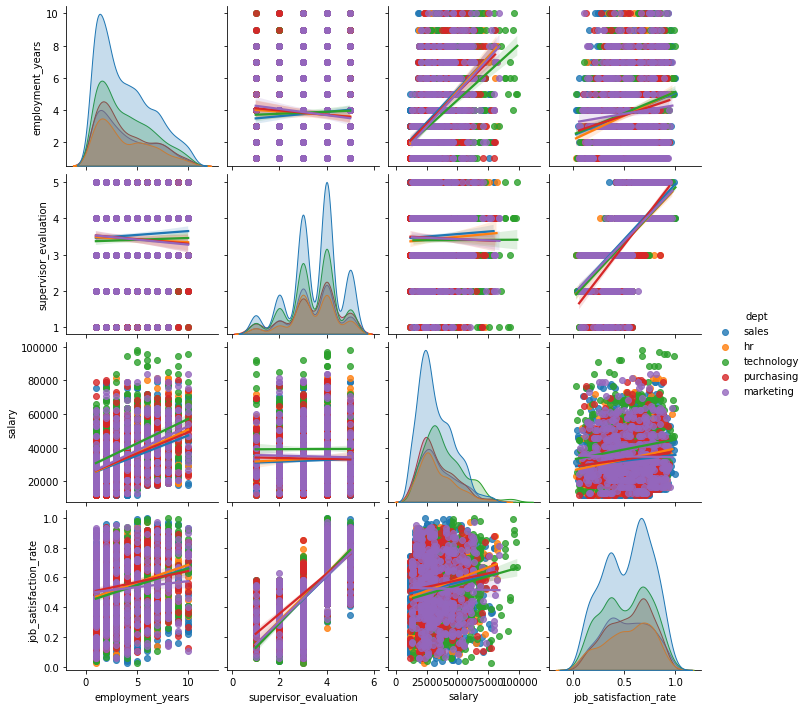

In [11]:
plt.figure(figsize=(15,12), dpi= 80)
sns.pairplot(train_job_satisfaction_rate, kind="reg", hue="dept")
plt.show()

In [12]:
train_job_satisfaction_rate.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


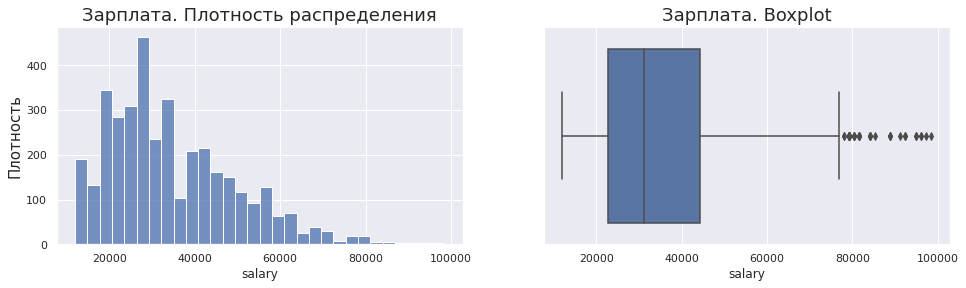

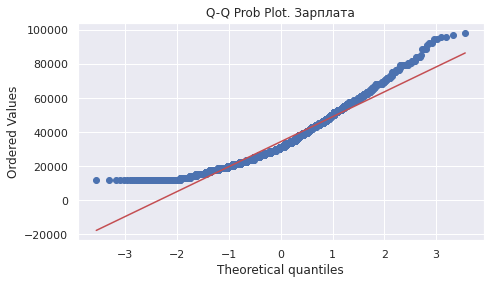

In [13]:
sns.set()
f, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title("Зарплата. Плотность распределения", fontsize=18)
axes[0].set_ylabel('Плотность', fontsize=15)
sns.histplot(train_job_satisfaction_rate['salary'], bins=30, ax=axes[0])
axes[1].set_title("Зарплата. Boxplot", fontsize=18)
sns.boxplot(data=train_job_satisfaction_rate, x = 'salary', ax=axes[1])
plt.figure(figsize=(16,4))
ax = plt.subplot(121)
st.probplot(train_job_satisfaction_rate['salary'], dist="norm", plot=plt)
ax.set_title("Q-Q Prob Plot. Зарплата")
plt.show()

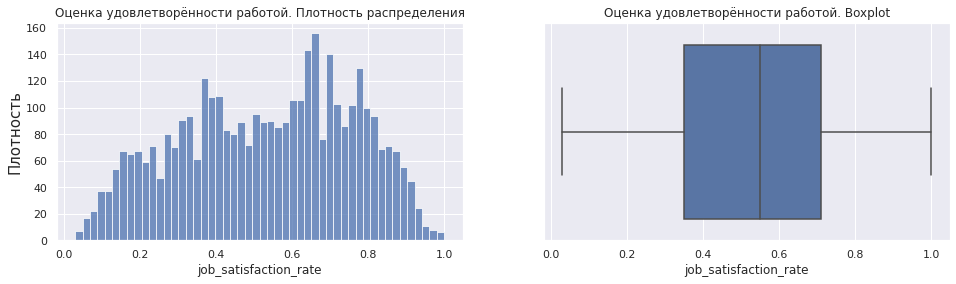

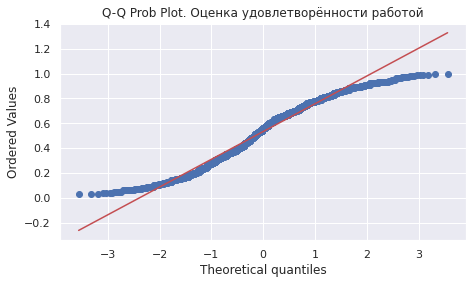

In [14]:
sns.set()
f, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title("Оценка удовлетворённости работой. Плотность распределения")
axes[0].set_ylabel('Плотность', fontsize=15)
sns.histplot(train_job_satisfaction_rate['job_satisfaction_rate'], bins=50, ax=axes[0])
axes[1].set_title("Оценка удовлетворённости работой. Boxplot")
sns.boxplot(data=train_job_satisfaction_rate, x = 'job_satisfaction_rate', ax=axes[1])
plt.figure(figsize=(16,4))
ax = plt.subplot(121)
st.probplot(train_job_satisfaction_rate['job_satisfaction_rate'], dist="norm", plot=plt)
ax.set_title("Q-Q Prob Plot. Оценка удовлетворённости работой")
plt.show()

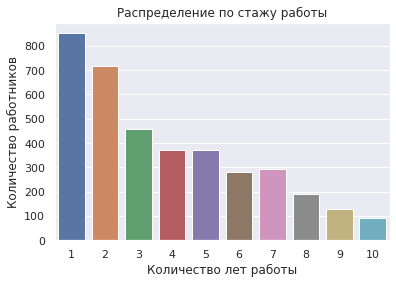

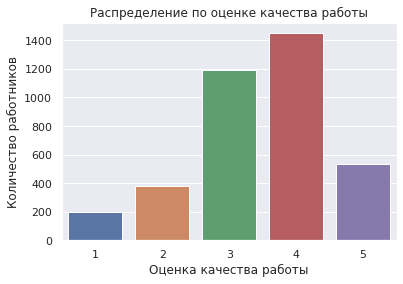

In [15]:

ax = sns.countplot(data = train_job_satisfaction_rate, x = 'employment_years')

ax.set_title('Распределение по стажу работы') 
plt.xlabel("Количество лет работы")
plt.ylabel('Количество работников')
plt.show()


ax = sns.countplot(data = train_job_satisfaction_rate, x = 'supervisor_evaluation')

ax.set_title('Распределение по оценке качества работы') 
plt.xlabel("Оценка качества работы")
plt.ylabel('Количество работников')


plt.show()

In [16]:
display(train_job_satisfaction_rate.head(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [17]:
def show_pie(data, data_label1):
    data.value_counts().plot(kind='pie', autopct='%1.0f%%')
    plt.title(data_label1)
    plt.show()


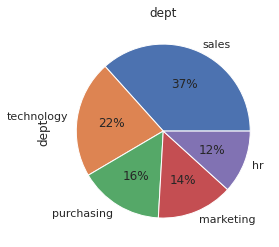

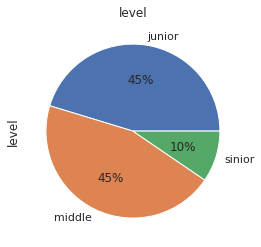

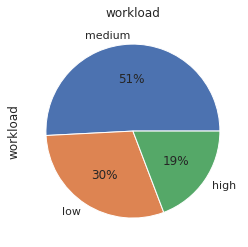

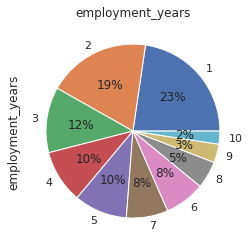

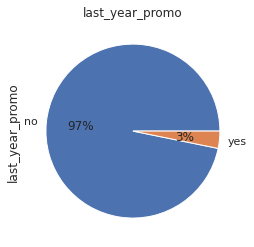

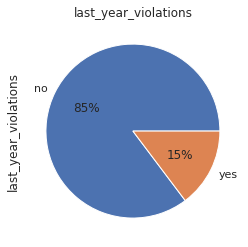

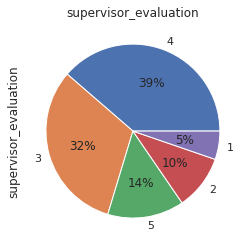

In [18]:
cat_col = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
for column in cat_col:
    show_pie(train_job_satisfaction_rate[column], column)

In [19]:
interval_cols = [
                 'salary',
                 'job_satisfaction_rate'
                ]

In [20]:
phik_overview = phik_matrix(train_job_satisfaction_rate, interval_cols=interval_cols) 

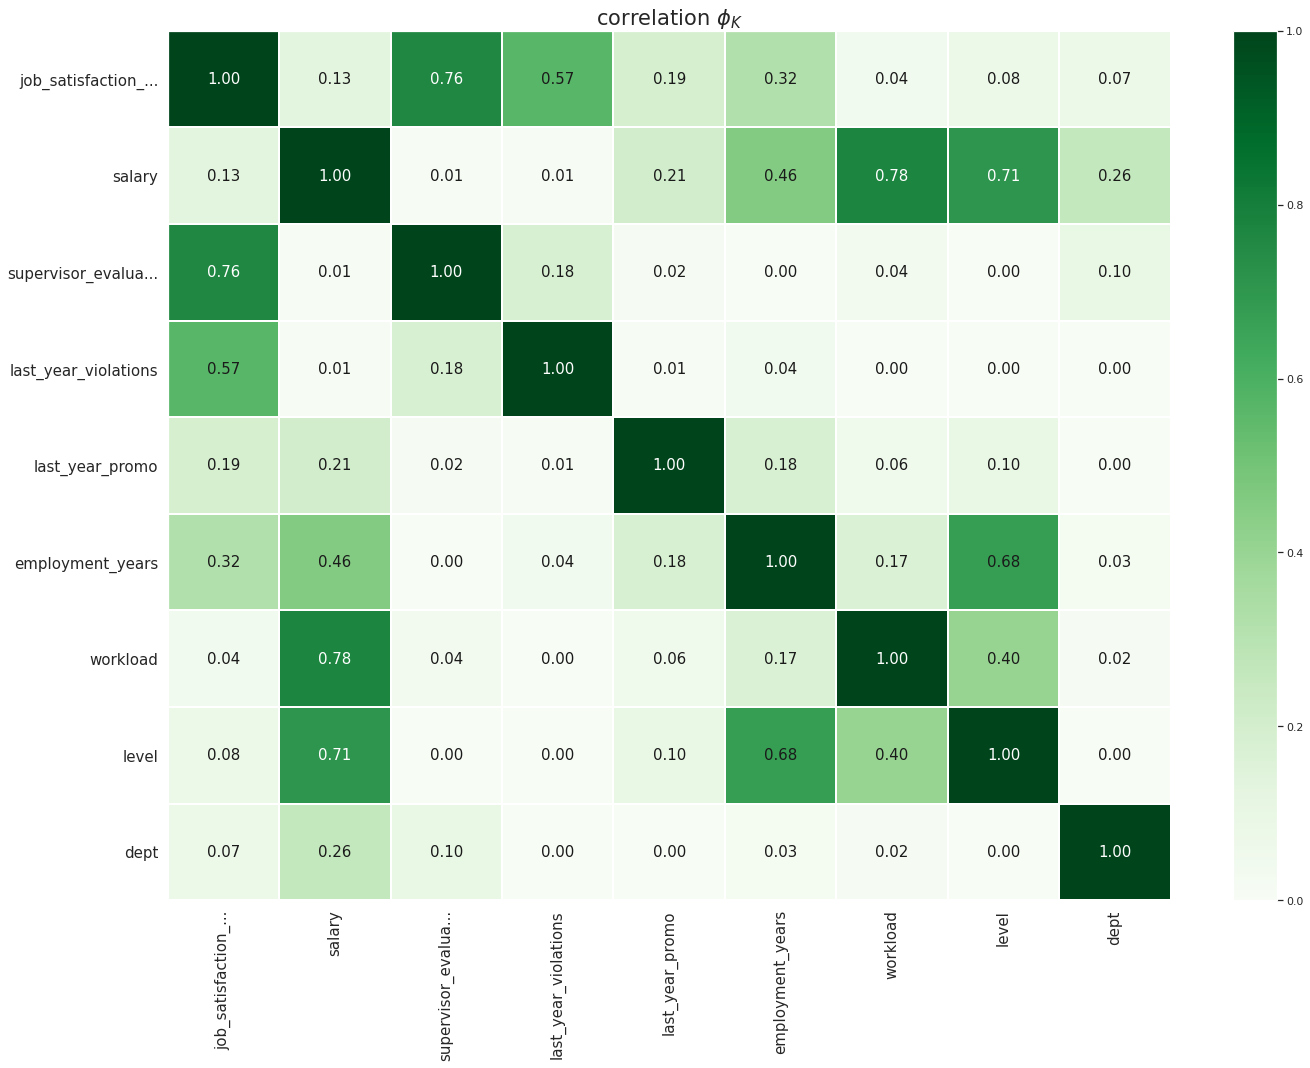

In [21]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Исследование данных позволило нам выявить следующие явления по признакам:  
    1) Зарплаты:  
    В распределении по зарплатам наблюдаются выбросы в большую сторону, 
    что подверждает различие между средним (34457) и медианным (31200) значениями.   
    Распределение имеет не нормальный вид.   
    Корреляция с оценкой удовлетворённости работой низкая (0.13)  
    2) Оценка удовлетворённости:  
    В распределении по оценке удволетворённости не наблюдаются сильные выбросы, 
    есть слабое различие между средним (0.53) и медианным (0.55) значениями.   
    Распределение имеет не нормальный вид.   
    3) Оценка качества работы от руководителя:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.76).    
    Присутствует различие между средним (3.46) и медианным (4.0) значениями.  
    Распределение по оценкам следующее:   
        4 - 39%    
        3 - 32%  
        5 - 14%  
        2 - 10%  
        1 - 5%  
    4) Количество нарушений за прошлый год:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.57).  
    Распределение по факту нарушений следующее: 
        да - 15%  
        нет - 85%  
    5) Наличие повышения в прошлом году:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.19).    
    Присутствует различие между средним (3.47) и медианным (4.0) значениями .  
    Распределение по факту нарушений следующее:  
        да - 3%  
        нет - 97%      
    6) Стаж в компании:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.32).    
    Присутствует различие между средним (3.8) и медианным (3.0) значениями.    
    В тройке самых распространённых показателей: 1 год - 23%, 2 года - 19%, 3 года - 12%   
    Наименьшую долю составляет стаж 10 лет - 2%    
    
    7) Нагрузка:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.04).   
    Распределение по нагрузке следующее:   
        Низкая - 30%    
        Средняя - 51%  
        Высокая - 19%  
       
    8) Уровень должности:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.08).   
    Распределение по должности следующее:   
        junior - 45%    
        middle - 45%  
        sinior - 10%      
        
    9) Департамент:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.07).  
    Распределение по департментам следующее:   
        'sales' - 37%    
        'technology' - 22%  
        'purchasing' - 16%  
        'marketing' - 14%  
        'hr' - 12%          
Мультиколлинеарность не наблюдается.    

#### Подготовка данных  

In [22]:
display(train_job_satisfaction_rate.head(5))
test_merged = test_features.merge(test_target_job_satisfaction_rate, on='id')
display(test_merged.head(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


In [23]:
num_cols = ['employment_years', 'salary', 'supervisor_evaluation']
 
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
 
ord_cols = ['level', 'workload']
 
cat_cols = ohe_cols + ord_cols
all_cols = num_cols + cat_cols
target_col = 'job_satisfaction_rate'

X_train = train_job_satisfaction_rate[all_cols]
y_train = train_job_satisfaction_rate[target_col]

X_test = test_merged[all_cols]
y_test = test_merged[target_col]


X_train.shape, y_train.shape

((3755, 8), (3755,))

In [24]:
ohe_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )


In [25]:
ord_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ord',OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
     ),
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )




In [26]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)



#### Обучение моделей  

In [27]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression(n_jobs=-1))
])

In [28]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': (None, *range(2, 11)),
        'models__max_features': range(2, 13),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [29]:
def own_metric(y_true, y):
    n = len(y_true)
    nom = 2*abs(y_true - y)
    denom = abs(y_true) + abs(y)
    summ = (nom/denom).sum()
    return summ*(100/n)
 
smape = make_scorer(own_metric, greater_is_better=False)

In [30]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=30,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=smape,
    n_jobs=-1
)

In [31]:
randomized_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                         'models__max_features': range(2, 13),
                                         'models__min_samples_leaf': range(1, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(own_metric, greater_is_better=False))

In [32]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SMAPE лучшей модели на кросс-валидации:', -round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [33]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10))


,rank_test_score,param_models,mean_test_score,params
18,1,DecisionTreeRegressor(random_state=42),-15.267942,"{'preprocessor__num': 'passthrough', 'models__..."
22,2,DecisionTreeRegressor(random_state=42),-15.762631,"{'preprocessor__num': StandardScaler(), 'model..."
2,3,DecisionTreeRegressor(random_state=42),-16.130555,"{'preprocessor__num': 'passthrough', 'models__..."
29,4,DecisionTreeRegressor(random_state=42),-16.321448,"{'preprocessor__num': MinMaxScaler(), 'models_..."
13,5,DecisionTreeRegressor(random_state=42),-17.205100,"{'preprocessor__num': StandardScaler(), 'model..."
21,6,DecisionTreeRegressor(random_state=42),-17.293309,"{'preprocessor__num': 'passthrough', 'models__..."
0,7,DecisionTreeRegressor(random_state=42),-17.295703,"{'preprocessor__num': 'passthrough', 'models__..."
11,8,DecisionTreeRegressor(random_state=42),-18.022345,"{'preprocessor__num': 'passthrough', 'models__..."
19,9,DecisionTreeRegressor(random_state=42),-18.263998,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,10,DecisionTreeRegressor(random_state=42),-18.289553,"{'preprocessor__num': 'passthrough', 'models__..."


In [34]:
display(result['param_models'].unique())

array([DecisionTreeRegressor(random_state=42)], dtype=object)

In [35]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(own_metric(y_test, y_test_pred), 2)}')

Метрика SMAPE на тестовой выборке: 13.7


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [36]:
warnings.filterwarnings('ignore')
X = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(randomized_search.best_estimator_['models'].predict, X)
shap_values1 = explainer(X)


PermutationExplainer explainer: 3756it [02:56, 20.53it/s]                          


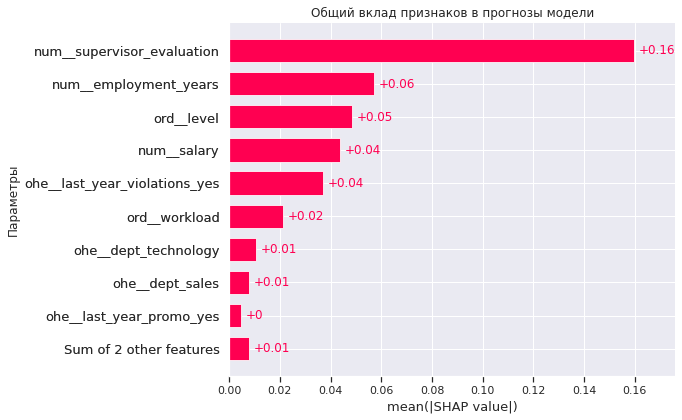

In [37]:
plt.title('Общий вклад признаков в прогнозы модели')
plt.ylabel('Параметры')
shap.plots.bar(shap_values1)

plt.show()


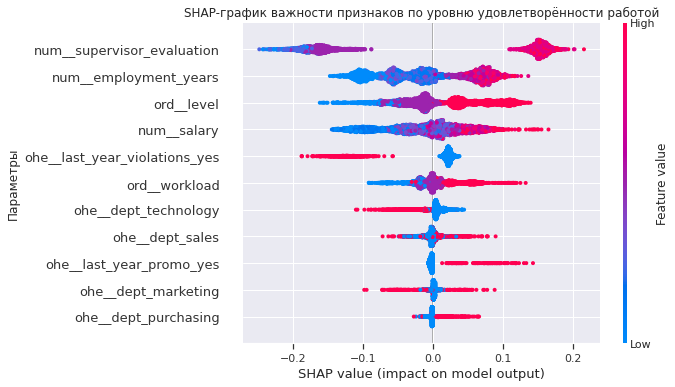

In [38]:
plt.title('SHAP-график важности признаков по уровню удовлетворённости работой')
plt.ylabel('Параметры')
shap.plots.beeswarm(shap_values1, max_display=16) 
plt.show()

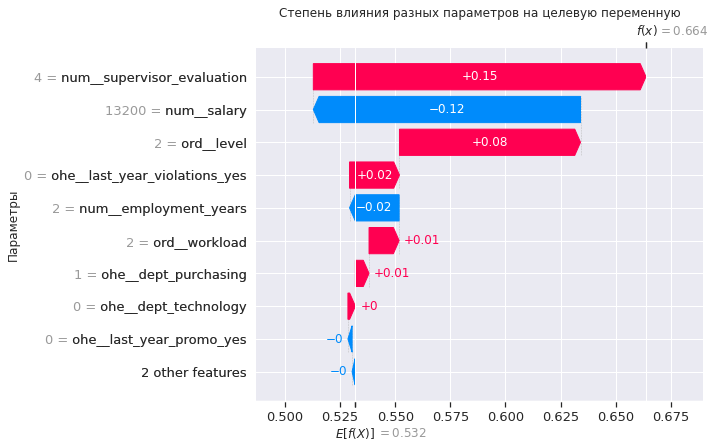

In [39]:
plt.title('Степень влияния разных параметров на целевую переменную')
plt.ylabel('Параметры')
shap.plots.waterfall(shap_values1[10]) 
plt.show()

На данном этапе были протестированны две модели: линейная и древо решений.    
Для оценки качества работы модели была использована использована метрика SMAPE.   
Лучше всего себя проявила модель DecisionTreeRegressor с параметрами:  
    max_features=8    
    min_samples_leaf=3    
    min_samples_split=5    
Модуль показателей метрики SMAPE для этой модели:  
    Тренировочная выборка: 15.27    
    Тестовая выборка: 13.7    
Наибольшим вкладом в формировании решения модели обладают следующие признаки:  
    - оценка руководителя (высокие значения склоняют к увеличению уровня удовлетворённости)  
    - зарплата (низкие значения склоняют к уменьшению уровня удовлетворённости)   
    - уровень работника (высокие значения склоняют к увеличению уровня удовлетворённости)   
    - нарушения (высокие значния склоняют к уменьшению уровня удовлетворённости)   
    - стаж (высокие значения склоняют к увеличению уровня удовлетворённости)  
     


#### Выводы

В ходе работы над разработкой модели предсказания оценки удовлетворённости работой были совершены следующие действия:  
1) Загрузка данных:  
Данные были загружены и представлены в трёх таблицах:
- train_job_satisfaction_rate: 10 столбцов, 4000 строк (в столбцах dept и level наблюдаются пропуски)
- test_features: 9 столбцов, 2000 строк (в столбцах dept и level наблюдаются пропуски)
- test_target_job_satisfaction_rate: 2 столбца, 2000 строк
2) Предобработка данных:  
В изначальных таблицах дублей обнаружено не было.    
После перевода в индексы строк  значений из столбца id, были обнаружены и удалены дубли в тренировочной выборке.    
После удаления количество записей в тренировочных выборках следующее:  
train_job_satisfaction_rate = 3755    

Типы данных в столбцах job_satisfaction_rate были заменены на float.  
Замечены пробелы и пропуски в значениях в столбцах dept, level, workload.    
Пропуски будут заполнены в пайплайне на этапе подготовки данных.    
Ошибок в написании не было обнаружено.     
3) Исследовательский анализ:  
Исследование данных позволило нам выявить следующие явления по признакам:  
- Зарплаты:  
    В распределении по зарплатам наблюдаются выбросы в большую сторону, 
    что подверждает различие между средним (34457) и медианным (31200) значениями.   
    Распределение имеет не нормальный вид.   
    Корреляция с оценкой удовлетворённости работой низкая (0.13)  
- Оценка удовлетворённости:  
    В распределении по оценке удволетворённости не наблюдаются сильные выбросы, 
    есть слабое различие между средним (0.53) и медианным (0.55) значениями.   
    Распределение имеет не нормальный вид.   
- Оценка качества работы от руководителя:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.76).    
    Присутствует различие между средним (3.46) и медианным (4.0) значениями.  
    Распределение по оценкам следующее:   
        4 - 39%    
        3 - 32%  
        5 - 14%  
        2 - 10%  
        1 - 5%  
- Количество нарушений за прошлый год:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.57).  
    Распределение по факту нарушений следующее: 
        да - 15%  
        нет - 85%  
- Наличие повышения в прошлом году:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.19).    
    Присутствует различие между средним (3.47) и медианным (4.0) значениями .  
    Распределение по факту нарушений следующее:  
        да - 3%  
        нет - 97%      
- Стаж в компании:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.32).    
    Присутствует различие между средним (3.8) и медианным (3.0) значениями.    
    В тройке самых распространённых показателей: 1 год - 23%, 2 года - 19%, 3 года - 12%   
    Наименьшую долю составляет стаж 10 лет - 2%    
    
- Нагрузка:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.04).   
    Распределение по нагрузке следующее:   
        Низкая - 30%    
        Средняя - 51%  
        Высокая - 19%  
       
- Уровень должности:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.08).   
    Распределение по должности следующее:   
        junior - 45%    
        middle - 45%  
        sinior - 10%      
        
- Департамент:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.07).  
    Распределение по департментам следующее:   
        'sales' - 37%    
        'technology' - 22%  
        'purchasing' - 16%  
        'marketing' - 14%  
        'hr' - 12%          
Мультиколлинеарность не наблюдается.       
4) Подготовка данных:  
Подготовка данных была произведена в пайплайне кодировщиками OrdinalEncoder и OneHotEncoding.  
На этом этапе было включено заполнение обнаруженных пропусков по принципы "наиболее частые значения".   
Численные данные были нормализованы с помощью MinMaxScaler.    
5) Обучение моделей:  
На данном этапе были обучены и протестированны две модели с вручную настроенным перебором гиперпараметров: линейная и древо решений.    
Для оценки качества работы модели была использована использована метрика SMAPE.     
Критерием успешности модели является показатель SMAPE ≤ 15.  
Лучше всего себя проявила модель DecisionTreeRegressor с параметрами:  
max_features=8  
min_samples_leaf=3  
min_samples_split=5  
Модуль показателей метрики SMAPE для этой модели:  
Тренировочная выборка: 15.27  
Тестовая выборка: 13.7    
Наибольшим вкладом в формировании решения модели обладают следующие признаки:  
    - оценка руководителя (высокие значения склоняют к увеличению уровня удовлетворённости)  
    - зарплата (низкие значения склоняют к уменьшению уровня удовлетворённости)   
    - уровень работника (высокие значения склоняют к увеличению уровня удовлетворённости)   
    - нарушения (высокие значния склоняют к уменьшению уровня удовлетворённости)   
    - стаж (высокие значения склоняют к увеличению уровня удовлетворённости)

### Задача 2. Предсказание увольнения сотрудника из компании  

#### Загрузка данных  

In [40]:
display(test_features.head(5))
test_features.info()

display(train_quit.head(5))
train_quit.info()

display(test_target_quit.head(5))
test_target_quit.info()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   employment_years       2587 non-null   int64 
 4   last_year_promo        2587 non-null   object
 5   last_year_violations   2587 non-null   object
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
 8   quit                   2587 non-null   object
dtypes: int64(3), object(6)
memory usage: 202.1+ KB


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


#### Предобработка данных  

In [41]:
#объединение таблиц для теста
test_quit_merged = test_features.merge(test_target_quit, on='id')
display(test_quit_merged.head(5))
test_quit_merged.info()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
 8   quit                   2000 non-null   object
dtypes: int64(3), object(6)
memory usage: 156.2+ KB


In [42]:
#просмотр уникальных строковых данных
display(test_features['dept'].unique(),
        test_features['level'].unique(),
        test_features['workload'].unique(),
        test_features['last_year_promo'].unique(),
        test_features['last_year_violations'].unique()
       )
display(train_quit['dept'].unique(),
        train_quit['level'].unique(),
        train_quit['workload'].unique(),
        train_quit['last_year_promo'].unique(),
        train_quit['last_year_violations'].unique(),
        train_quit['quit'].unique()
       )
display(test_target_quit['quit'].unique())


array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

array(['middle', 'junior', 'sinior'], dtype=object)

array(['high', 'medium', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['yes', 'no'], dtype=object)

В изначальных таблицах дублей обнаружено не было.    
После перевода в индексы строк  значений из столбца id, были обнаружены и удалены дубли.    
После удаления дублей количество записей в тренировочных выборках следующее:  
train_quit = 2587 
Замечены пробелы и пропуски в значениях в столбцах dept, level, workload.    
Пропуски будут заполнены в пайплайне на этапе подготовки данных.    
Ошибок в написании не было обнаружено.  

#### Исследовательский анализ данных  

In [43]:
train_quit.describe()


,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


<Figure size 1200x960 with 0 Axes>

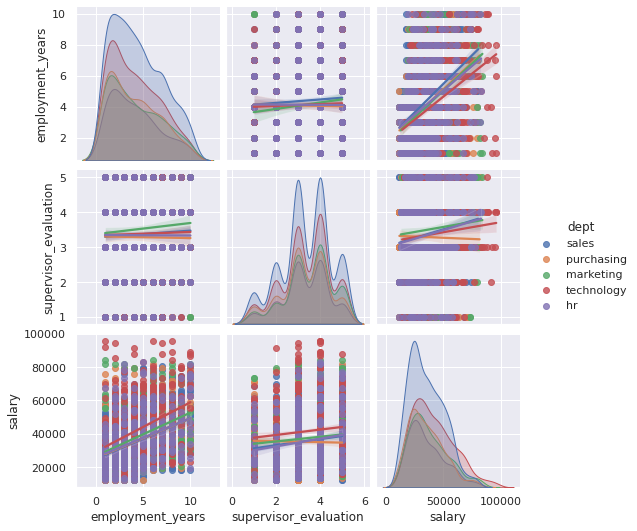

In [44]:
plt.figure(figsize=(15,12), dpi= 80)
sns.pairplot(train_quit, kind="reg", hue="dept")
plt.show()

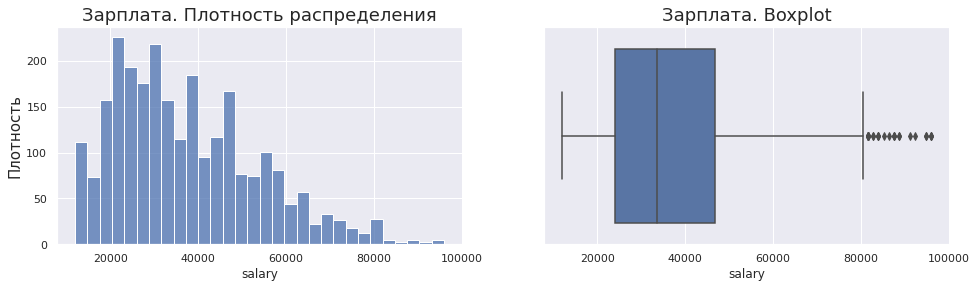

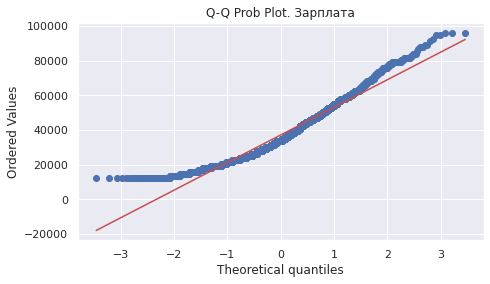

In [45]:
sns.set()
f, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title("Зарплата. Плотность распределения", fontsize=18)
axes[0].set_ylabel('Плотность', fontsize=15)
sns.histplot(train_quit['salary'], bins=30, ax=axes[0])
axes[1].set_title("Зарплата. Boxplot", fontsize=18)
sns.boxplot(data=train_quit, x = 'salary', ax=axes[1])
plt.figure(figsize=(16,4))
ax = plt.subplot(121)
st.probplot(train_quit['salary'], dist="norm", plot=plt)
ax.set_title("Q-Q Prob Plot. Зарплата")
plt.show()

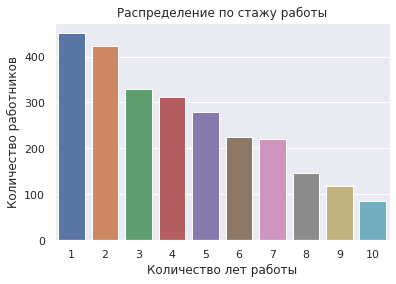

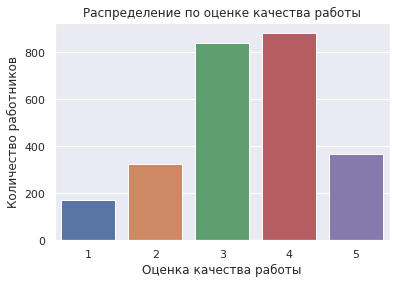

In [46]:

ax = sns.countplot(data = train_quit, x = "employment_years")

ax.set_title('Распределение по стажу работы') 
plt.xlabel("Количество лет работы")
plt.ylabel('Количество работников')
plt.show()


ax = sns.countplot(data = train_quit, x = "supervisor_evaluation")

ax.set_title('Распределение по оценке качества работы') 
plt.xlabel("Оценка качества работы")
plt.ylabel('Количество работников')


plt.show()

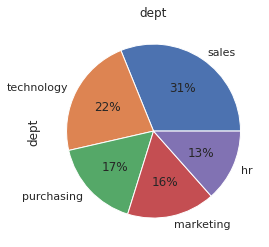

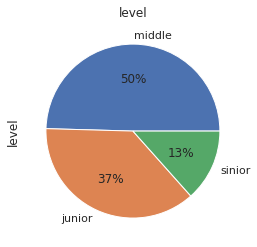

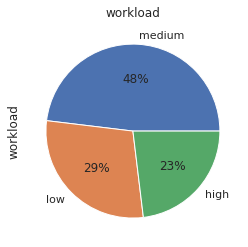

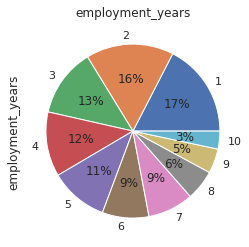

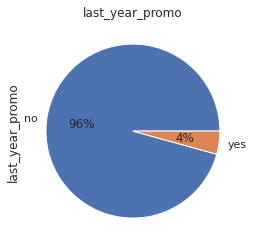

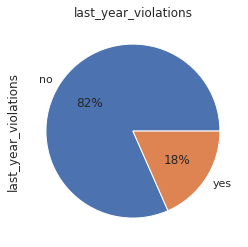

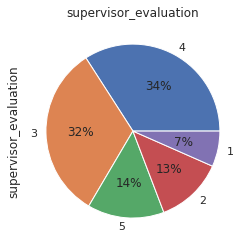

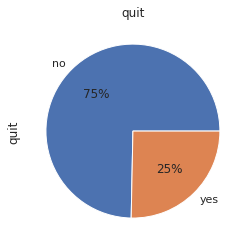

In [47]:
cat_col = ['dept', 
           'level', 
           'workload', 
           'employment_years', 
           'last_year_promo', 
           'last_year_violations', 
           'supervisor_evaluation', 
           'quit'
          ]
for column in cat_col:
    show_pie(train_quit[column], column)

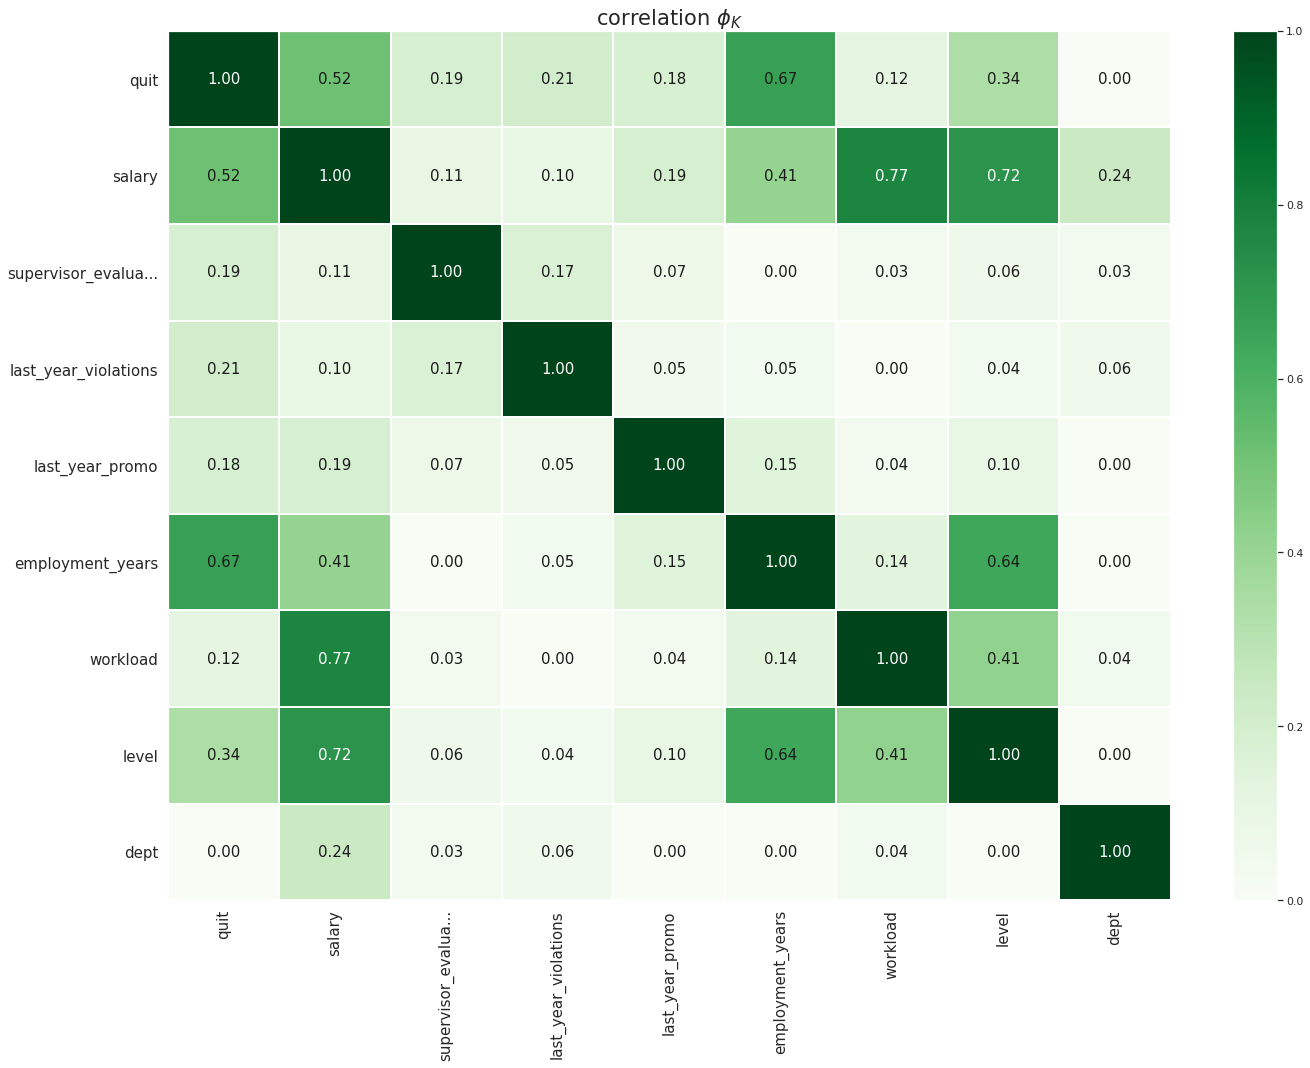

In [48]:

interval_cols = [
                 'salary',
                 'job_satisfaction_rate'
                ]


phik_overview = phik_matrix(train_quit, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [49]:
#портрет «уволившегося сотрудника»

In [50]:
train_quit_yes = train_quit.query('quit == "yes"')
train_quit_no = train_quit.query('quit == "no"')
display(train_quit_yes.head(5), train_quit_no.head(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
257132,sales,junior,medium,2,no,yes,3,24000,yes
699916,sales,junior,low,1,no,yes,3,18000,yes
613206,technology,middle,medium,2,no,no,3,45600,yes
468145,technology,junior,medium,2,no,no,3,30000,yes
982346,marketing,junior,medium,3,no,no,3,30000,yes


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
910140,marketing,junior,medium,2,no,no,5,25200,no
417070,technology,middle,medium,8,no,no,2,44400,no


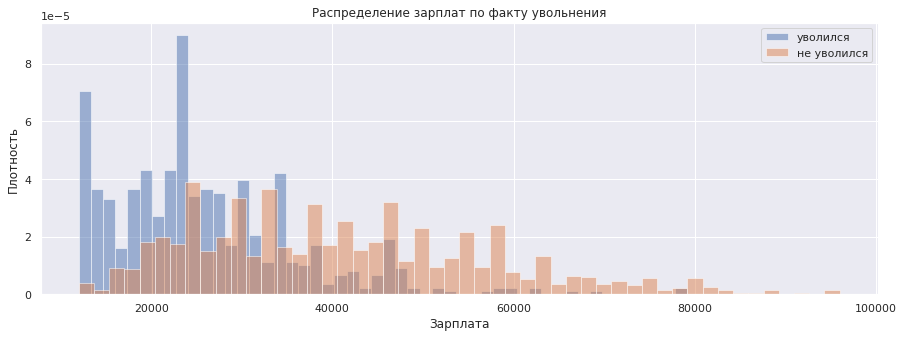

count      655.000000
mean     25767.938931
std      10484.828614
min      12000.000000
5%       12000.000000
25%      18000.000000
50%      24000.000000
75%      30600.000000
95%      46800.000000
99%      60000.000000
max      79200.000000
Name: salary, dtype: float64

count     1932.000000
mean     40952.173913
std      16085.739667
min      12000.000000
5%       19200.000000
25%      27600.000000
50%      39000.000000
75%      51600.000000
95%      70800.000000
99%      81600.000000
max      96000.000000
Name: salary, dtype: float64

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))



ax.hist(train_quit_yes['salary'], 50, alpha=0.5, density=True, label='уволился')
ax.hist(train_quit_no['salary'], 50, alpha=0.5, density=True, label='не уволился')

plt.title('Распределение зарплат по факту увольнения')
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.legend()
plt.show()


plt.show()
display(
    train_quit_yes['salary'].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]),
    train_quit_no['salary'].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])
)

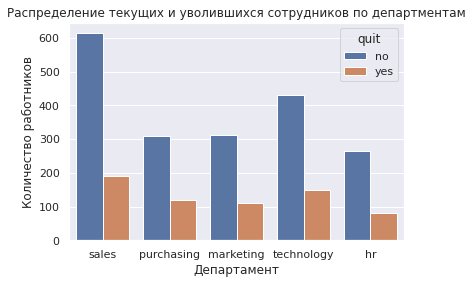

In [52]:

ax = sns.countplot(data = train_quit, x = 'dept', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по департментам') 
plt.xlabel("Департамент")
plt.ylabel('Количество работников')


plt.show()

In [53]:
quit_rate_dept=train_quit_yes['dept'].value_counts() / train_quit_no['dept'].value_counts()
display(quit_rate_dept)


hr            0.308271
marketing     0.360129
purchasing    0.387097
sales         0.311075
technology    0.348028
Name: dept, dtype: float64

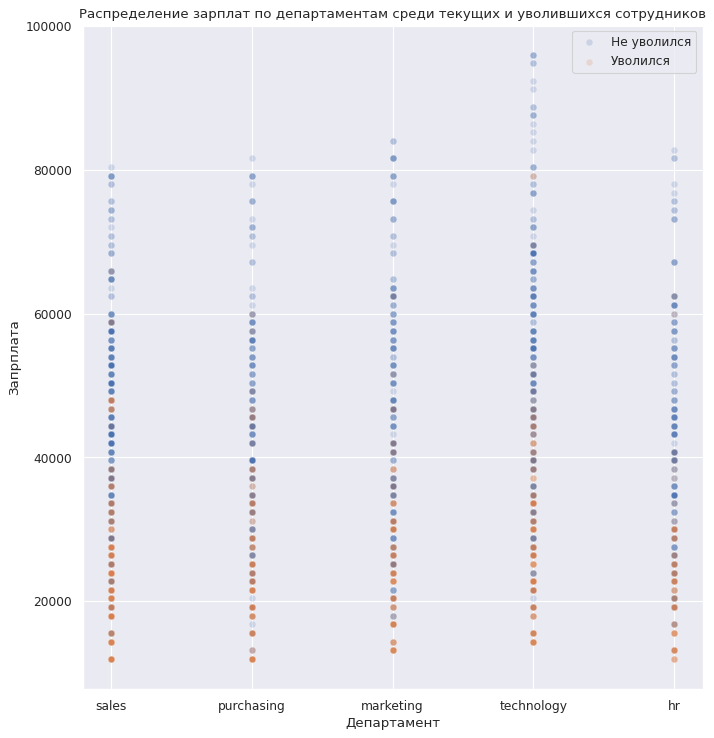

0.6153846153846154

In [54]:
plt.figure(figsize=(10,11), dpi= 80)
ax2 = sns.scatterplot(data=train_quit_no, x='dept', y='salary', alpha=0.2, label='Не уволился')
ax2 = sns.scatterplot(data=train_quit_yes, x='dept', y='salary', alpha=0.2, label='Уволился')
ax2.set_title('Распределение зарплат по департаментам среди текущих и уволившихся сотрудников')
plt.xlabel("Департамент")
plt.ylabel('Запрплата')
plt.show()

display(train_quit_yes['salary'].median() / train_quit_no['salary'].median())

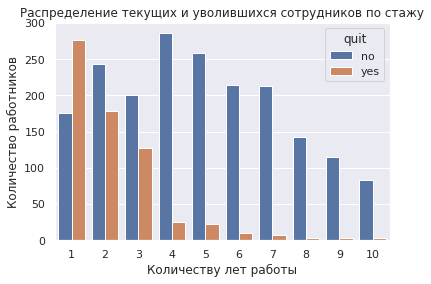

In [55]:

ax = sns.countplot(data = train_quit, x = 'employment_years', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по стажу') 
plt.xlabel("Количеству лет работы")
plt.ylabel('Количество работников')


plt.show()

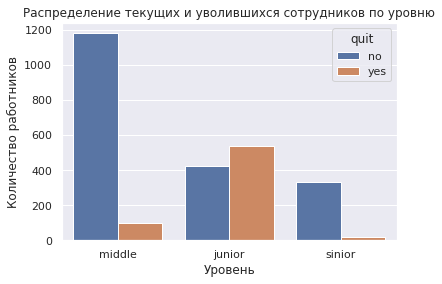

In [56]:

ax = sns.countplot(data = train_quit, x = 'level', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по уровню') 
plt.xlabel("Уровень")
plt.ylabel('Количество работников')


plt.show()

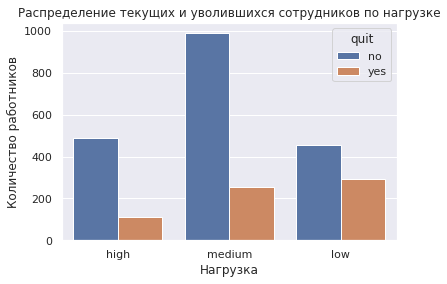

In [57]:

ax = sns.countplot(data = train_quit, x = 'workload', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по нагрузке') 
plt.xlabel("Нагрузка")
plt.ylabel('Количество работников')


plt.show()

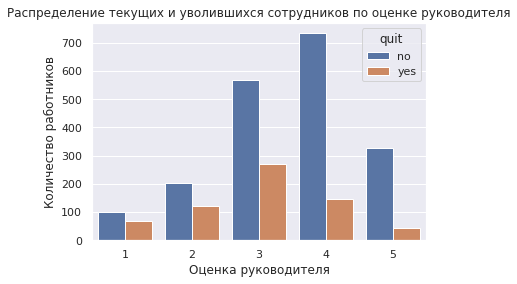

In [58]:

ax = sns.countplot(data = train_quit, x = 'supervisor_evaluation', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по оценке руководителя') 
plt.xlabel("Оценка руководителя")
plt.ylabel('Количество работников')


plt.show()

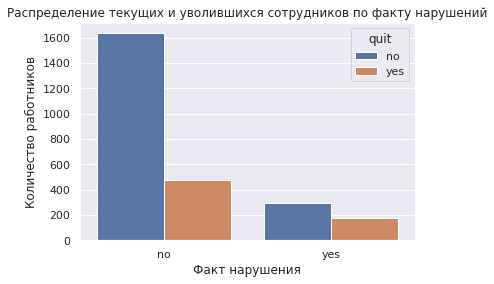

In [59]:

ax = sns.countplot(data = train_quit, x = 'last_year_violations', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по факту нарушений') 
plt.xlabel("Факт нарушения")
plt.ylabel('Количество работников')


plt.show()

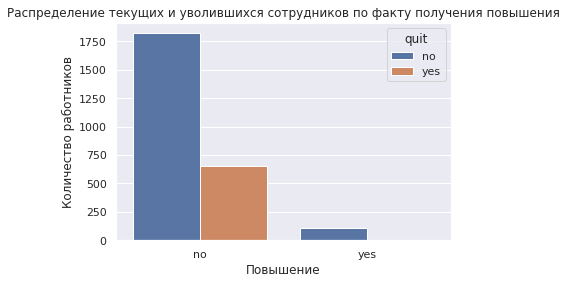

In [60]:

ax = sns.countplot(data = train_quit, x = 'last_year_promo', hue='quit')

ax.set_title('Распределение текущих и уволившихся сотрудников по факту получения повышения') 
plt.xlabel("Повышение")
plt.ylabel('Количество работников')


plt.show()

In [61]:
sat_quit_test = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
display(sat_quit_test.head(5), sat_quit_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
 1   quit                   2000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 46.9+ KB


,job_satisfaction_rate,quit
id,,
130604,0.74,no
825977,0.75,no
418490,0.60,yes
555320,0.72,no
826430,0.08,yes


None

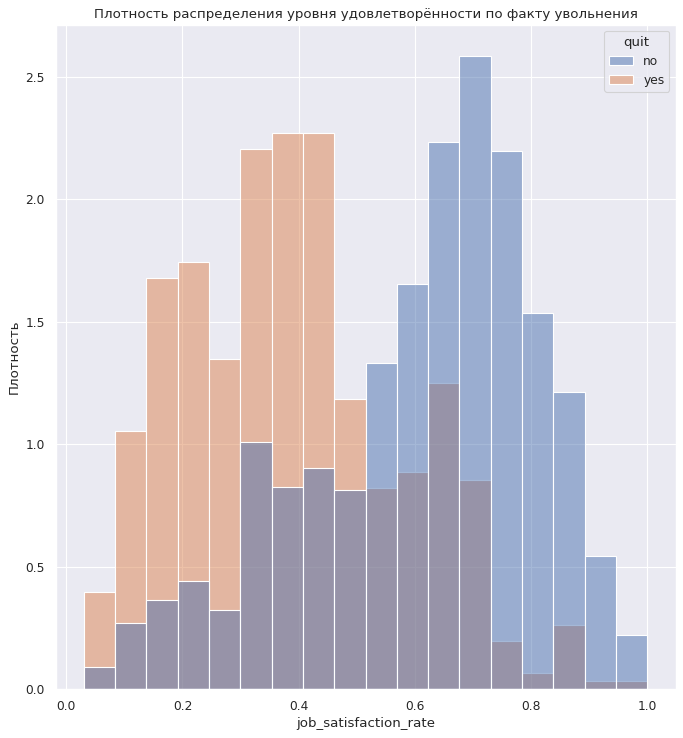

In [62]:
plt.figure(figsize=(10,11), dpi= 80)
ax2 = sns.histplot(data=sat_quit_test, hue='quit', x='job_satisfaction_rate', stat='density', common_norm=False)

plt.ylabel('Плотность')
ax2.set_title('Плотность распределения уровня удовлетворённости по факту увольнения')
plt.show()


In [63]:
display(sat_quit_test.groupby('quit')['job_satisfaction_rate'].median() )

quit
no     0.66
yes    0.37
Name: job_satisfaction_rate, dtype: float64

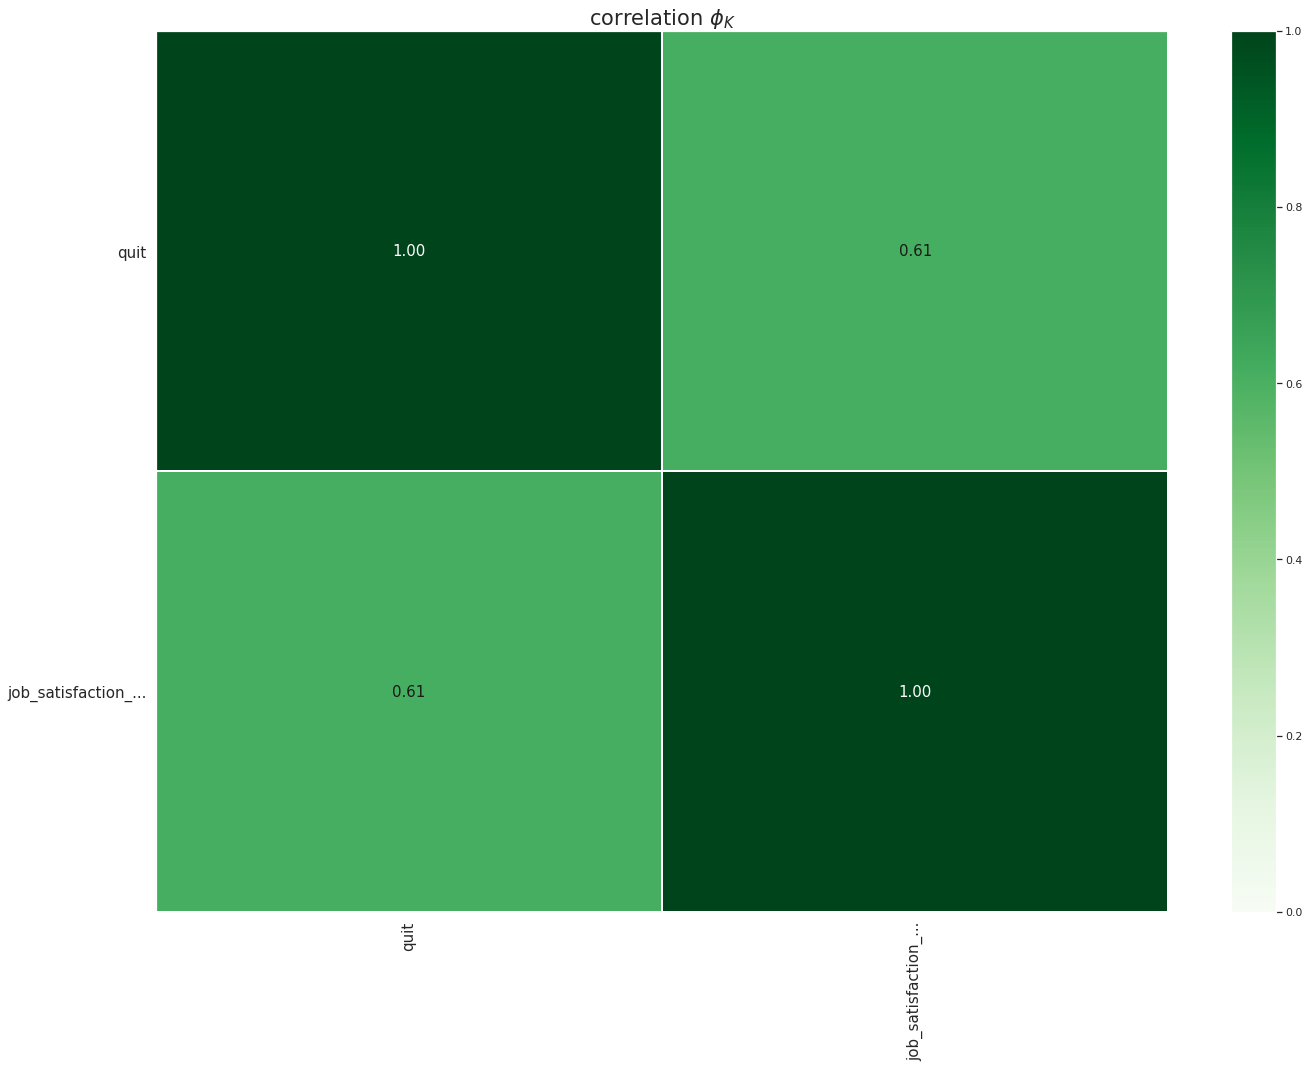

In [64]:
phik_overview = phik_matrix(sat_quit_test, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Исследование данных позволило нам выявить следующие явления по признакам:  
    1) Зарплаты:  
    В распределении по зарплатам наблюдаются выбросы в большую сторону, 
    что подверждает различие между средним (37107) и медианным (33600) значениями.   
    Распределение имеет не нормальный вид.   
    Корреляция с фактом увольнения ощутимая = 0.52   
    2) Факт увольнения:    
    Процентное соотношение следующее:  
        - да: 25%  
        - нет: 75%  
    При составлении phik- матрицы с оценкой удовлетворённости работой 
    был обнаружен сильный коэффициент корреляции = 0.61.  
    Далее этот параметр будет добавлен во входные данные.  
    Также по плотности распределения уровня удовлетворённости по факту увольнения наблюдаем, 
    что у уволившихся сотрудников медиана этого показателя почти вдвое ниже:    
        - да: 0.37  
        - нет: 0.66  
        
    3) Оценка качества работы от руководителя:  
    Наблюдается слабая корреляция с фактом увольнения (0.19).    
    Присутствует различие между средним (3.36) и медианным (3.0) значениями.  
    Распределение по оценкам следующее:   
        4 - 34%    
        3 - 32%  
        5 - 14%  
        2 - 13%  
        1 - 7%  
    4) Количество нарушений за прошлый год:  
    Наблюдается сильная корреляция с фактом увольнения (0.21).  
    Распределение по факту нарушений следующее: 
        да - 18%  
        нет - 82%  
    5) Наличие повышения в прошлом году:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.18).    
    Присутствует различие между средним (3.47) и медианным (4.0) значениями .  
    Распределение по факту нарушений следующее:  
        да - 4%  
        нет - 96%      
    6) Стаж в компании:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.67).    
    Присутствует различие между средним (3.7) и медианным (3.0) значениями.    
    В тройке самых распространённых показателей: 1 год - 17%, 2 года - 16%, 3 года - 13%   
    Наименьшую долю составляет стаж 10 лет - 3%    
    
    7) Нагрузка:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.12).   
    Распределение по нагрузке следующее:   
        Низкая - 29%    
        Средняя - 48%  
        Высокая - 23%  
       
    8) Уровень должности:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.34).   
    Распределение по должности следующее:   
        junior - 37%    
        middle - 50%  
        sinior - 13%      
        
    9) Департамент:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.00).  
    Распределение по департментам следующее:   
        'sales' - 31%    
        'technology' - 22%  
        'purchasing' - 17%  
        'marketing' - 16%  
        'hr' - 13%          
Мультиколлинеарность не наблюдается.    

При составлении портрета уволившегося сотрудника выяснили следующее:    
    1) Наиобильшее соотношение уволившихся к оставшимся в департаменте комплектования (0.38), наименьшее - в HR(0.30)     
    2) Соотношение медиан зарплат уволившихся к оставшимся = 0.61 - зарплаты первой группы ниже на 39%    
    3) Медиана удовлетворённости работой у уволившихся = 0.37, у оставшихся = 0.66    
    4) Количество уволившихся превалирует среди группы сотрудников со стажем меньше 4 лет      
    5) Количество уволившихся превалирует среди группы сотрудников с уровнем junior    
    6) Количество уволившихся превалирует среди группы сотрудников с низким уровнем нагрузки   
    7) Группа уволившихся сотрудников превалирует среди тех, кого руководитель оценил ниже 4 баллов  
    8) Группа уволившихся сотрудников превалирует среди тех, кто соврешал нарушения в прошлом году  
    9) В группе не получивших повышение почти в равной степени представлены и уволившиеся сотрудники, и оставшиеся  
    
    
    
  

#### Добавление нового входного признака  

In [65]:
model = randomized_search.best_estimator_
result_sat_train = pd.DataFrame(model.predict(train_quit), columns = ['job_satisfaction_rate_pred'], index=train_quit.index)
display(result_sat_train)

,job_satisfaction_rate_pred
id,
723290,0.605000
814010,0.846364
155091,0.342000
257132,0.340000
910140,0.832000
...,...
778735,0.848333
106936,0.880000
775320,0.463333


In [66]:
model = randomized_search.best_estimator_
result_sat_test = pd.DataFrame(model.predict(X_test), columns = ['job_satisfaction_rate_pred'], index=X_test.index)
display(result_sat_test.head(5))

,job_satisfaction_rate_pred
id,
485046,0.832000
686555,0.682222
467458,0.675714
418655,0.713333
789145,0.812500


In [67]:
sat_quit_test = test_quit_merged.merge(result_sat_test, left_index=True, right_index=True)
display(sat_quit_test.head(5))

sat_quit_train=train_quit.merge(result_sat_train, left_index=True, right_index=True)
display(sat_quit_train.head(5))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.832000
686555,hr,junior,medium,1,no,no,4,30000,no,0.682222
467458,sales,middle,low,5,no,no,4,19200,no,0.675714
418655,sales,middle,low,6,no,no,4,19200,no,0.713333
789145,hr,middle,medium,5,no,no,5,40800,no,0.812500


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.342000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.832000


#### Подготовка данных  

In [68]:
#замена бинарных значений на 1/0
#sat_quit_train['quit'] = sat_quit_train['quit'].replace({'no': 0, 'yes': 1})
#sat_quit_test['quit'] = sat_quit_test['quit'].replace({'no': 0, 'yes': 1})

lab_encode = LabelEncoder()
sat_quit_train['quit'] = lab_encode.fit_transform(sat_quit_train['quit'])
sat_quit_test['quit'] = lab_encode.transform(sat_quit_test['quit'])

In [69]:
num_cols2 = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate_pred']
 
ohe_cols2 = ['dept', 'last_year_promo', 'last_year_violations']
 
ord_cols2 = ['level', 'workload']
 
cat_cols2 = ohe_cols2 + ord_cols2
all_cols2 = num_cols2 + cat_cols2
target_col2 = 'quit'
    

X_quit_train = sat_quit_train[all_cols2]
y_quit_train = sat_quit_train[target_col2]

X_quit_test = sat_quit_test[all_cols2]
y_quit_test = sat_quit_test[target_col2]


X_quit_train.shape, y_quit_train.shape

((2587, 9), (2587,))

In [70]:
ohe_pipe2 = Pipeline(
    [
    (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [71]:
ord_pipe2 = Pipeline(
    [
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ord',OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
     ),
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [72]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe2, ohe_cols2),
        ('ord', ord_pipe2, ord_cols2),
        ('num', MinMaxScaler(), num_cols2)
    ], 
    remainder='passthrough'
)

#### Обучение модели  

In [73]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [74]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': (None, *range(2, 17)),
        'models__max_features': range(2, 17),
        'models__min_samples_split': range(2, 17),
        'models__min_samples_leaf': range(1, 17),
        
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [75]:
randomized_search2 = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=50,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

In [76]:
randomized_search2.fit(X_quit_train, y_quit_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                         'models__min_samples_split': range(2, 17),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [77]:
print('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', round(randomized_search2.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [78]:
best_model = randomized_search2.best_estimator_
y_test_pred = best_model.predict_proba(X_quit_test)[:, 1]

display(y_test_pred)

array([0.12903226, 0.14814815, 0.06818182, ..., 0.95061728, 0.21428571,
       0.04166667])

In [79]:
roc_auc_test = roc_auc_score(y_quit_test, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_test}')

Метрика ROC-AUC на тестовой выборке: 0.9237934372468836


In [80]:
warnings.filterwarnings('ignore')
X = randomized_search2.best_estimator_['preprocessor'].fit_transform(X_quit_train)
X = pd.DataFrame(X, columns = randomized_search2.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(randomized_search2.best_estimator_['models'].predict, X)
shap_values2 = explainer(X)


PermutationExplainer explainer: 2588it [01:53, 20.69it/s]                          


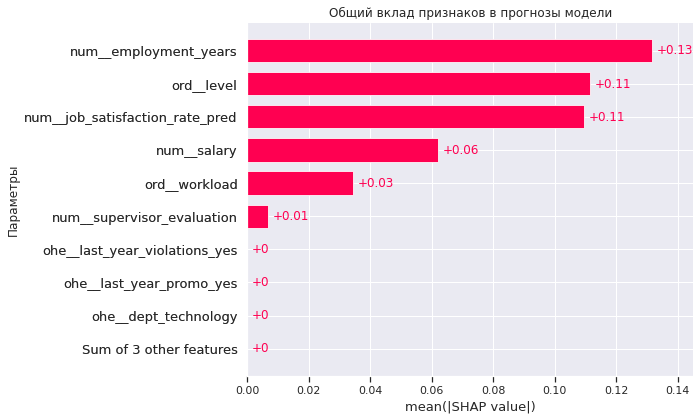

In [81]:
plt.title('Общий вклад признаков в прогнозы модели')
plt.ylabel('Параметры')
shap.plots.bar(shap_values2)
plt.show()

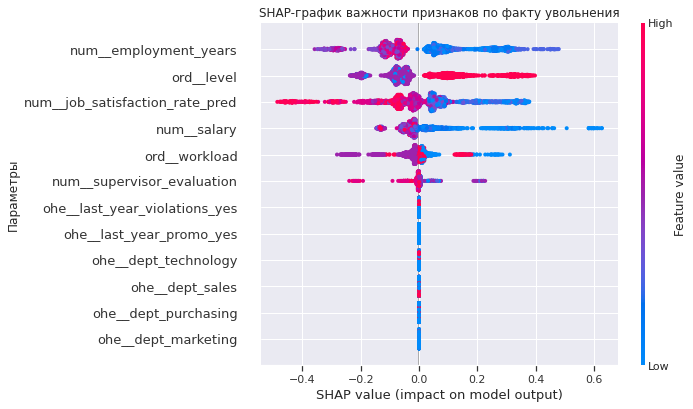

In [82]:
plt.title('SHAP-график важности признаков по факту увольнения')
plt.ylabel('Параметры')
shap.plots.beeswarm(shap_values2, max_display=16) 
plt.show()

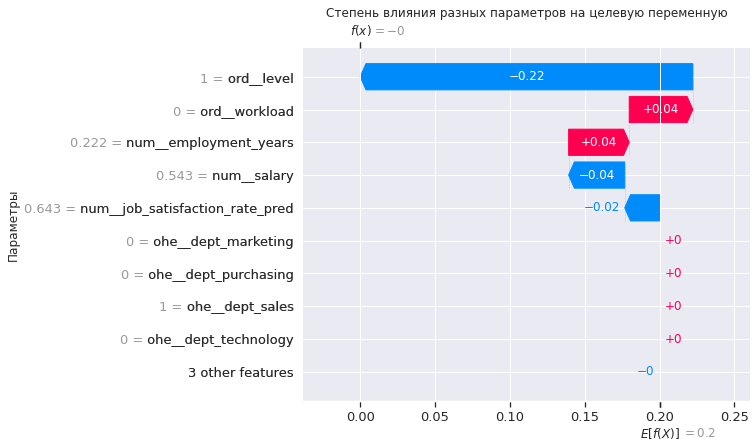

In [83]:
plt.title('Степень влияния разных параметров на целевую переменную')
plt.ylabel('Параметры')
shap.plots.waterfall(shap_values2[10]) 
plt.show()

На данном этапе были обучены и протестированны три модели с вручную настроенным перебором гиперпараметров:   
DecisionTreeClassifier, KNeighborsClassifier и SVC.    
Для оценки качества работы модели была использована использована метрика ROC-AUC.     
Критерием успешности модели является показатель ROC-AUC ≥ 0.91.  
Лучше всего себя проявила модель DecisionTreeRegressor с параметрами:  
    max_features=5    
    min_samples_leaf=11    
    max_depth=7    
    min_samples_split=10  
Модуль показателей метрики SMAPE для этой модели:  
    Тренировочная выборка: 0.9  
    Тестовая выборка: 0.92    
Наибольшим вкладом в принятие решения моделью обладают следующие признаки:  
- стаж работы (высокие значения склоняют к классу 0(не уволился)) 
- уровень удовлетворённости  (высокие значения склоняют к классу 0(не уволился)) 
- уровень работника (высокие значения склоняют к классу 1(уволился))   
- зарплата  (низкие значения склоняют к классу 1(уволился)) 
- рабочая загрузка (низкие значения склоняют к классу 1(уволился)) 


#### Выводы  

В ходе работы над разработкой модели предсказания факта увольнения были совершены следующие действия:  
1) Загрузка данных:  
Данные были загружены и представлены в трёх таблицах:
- test_features: 9 столбцов, 2000 строк (в столбцах dept и level наблюдаются пропуски)
- train_quit: 10 столбцов, 4000 строк
- test_target_quit: 2 столбца, 2000 строк  
2) Предобработка данных:  
В изначальных таблицах дублей обнаружено не было.    
После перевода в индексы строк  значений из столбца id, были обнаружены и удалены дубли в тренировочной выборке.    
После удаления количество записей в тренировочных выборках следующее:  
train_quit = 2587    
Замечены пробелы и пропуски в значениях в столбцах dept, level, workload.   
Ошибок в написании строковых данных не было обнаружено.    
3) Исследовательский анализ:  
Исследование данных позволило нам выявить следующие явления по признакам:  
- Зарплаты:  
    В распределении по зарплатам наблюдаются выбросы в большую сторону, 
    что подверждает различие между средним (37107) и медианным (33600) значениями.   
    Распределение имеет не нормальный вид.   
    Корреляция с фактом увольнения ощутимая = 0.52   
- Факт увольнения:    
    Процентное соотношение следующее:  
        - да: 25%  
        - нет: 75%  
    При составлении phik- матрицы с оценкой удовлетворённости работой 
    был обнаружен сильный коэффициент корреляции = 0.61.  
    Далее этот параметр будет добавлен во входные данные.  
    Также по плотности распределения уровня удовлетворённости по факту увольнения наблюдаем, 
    что у уволившихся сотрудников медиана этого показателя почти вдвое ниже:    
        - да: 0.37  
        - нет: 0.66  
        
- Оценка качества работы от руководителя:  
    Наблюдается слабая корреляция с фактом увольнения (0.19).    
    Присутствует различие между средним (3.36) и медианным (3.0) значениями.  
    Распределение по оценкам следующее:   
        4 - 34%    
        3 - 32%  
        5 - 14%  
        2 - 13%  
        1 - 7%  
- Количество нарушений за прошлый год:  
    Наблюдается сильная корреляция с фактом увольнения (0.21).  
    Распределение по факту нарушений следующее: 
        да - 18%  
        нет - 82%  
- Наличие повышения в прошлом году:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.18).    
    Присутствует различие между средним (3.47) и медианным (4.0) значениями .  
    Распределение по факту нарушений следующее:  
        да - 4%  
        нет - 96%      
- Стаж в компании:  
    Наблюдается сильная корреляция с оценкой удовлетворённости работой (0.67).    
    Присутствует различие между средним (3.7) и медианным (3.0) значениями.    
    В тройке самых распространённых показателей: 1 год - 17%, 2 года - 16%, 3 года - 13%   
    Наименьшую долю составляет стаж 10 лет - 3%    
    
- Нагрузка:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.12).   
    Распределение по нагрузке следующее:   
        Низкая - 29%    
        Средняя - 48%  
        Высокая - 23%  
       
- Уровень должности:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.34).   
    Распределение по должности следующее:   
        junior - 37%    
        middle - 50%  
        sinior - 13%      
        
- Департамент:  
    Наблюдается слабая корреляция с оценкой удовлетворённости работой (0.00).  
    Распределение по департментам следующее:   
        'sales' - 31%    
        'technology' - 22%  
        'purchasing' - 17%  
        'marketing' - 16%  
        'hr' - 13%          
Мультиколлинеарность не наблюдается.      
Также на данном этапе был добавлен дополнительный входной признак job_satisfaction_rate_pred 
- предсказанная с помощью лучшей модели из задачи 1 оценка удовлетворённости работой.  
Учитывая новый признак при составлении портрета уволившегося сотрудника выяснили следующее:    
    1) Наиобильшее соотношение уволившихся к оставшимся в департаменте комплектования (0.38), наименьшее - в HR(0.30)     
    2) Соотношение медиан зарплат уволившихся к оставшимся = 0.61 - зарплаты первой группы ниже на 39%    
    3) Медиана удовлетворённости работой у уволившихся = 0.37, у оставшихся = 0.66    
    4) Количество уволившихся превалирует среди группы сотрудников со стажем меньше 4 лет      
    5) Количество уволившихся превалирует среди группы сотрудников с уровнем junior    
    6) Количество уволившихся превалирует среди группы сотрудников с низким уровнем нагрузки   
    7) Группа уволившихся сотрудников превалирует среди тех, кого руководитель оценил ниже 4 баллов  
    8) Группа уволившихся сотрудников превалирует среди тех, кто соврешал нарушения в прошлом году  
    9) В группе не получивших повышение почти в равной степени представлены и уволившиеся сотрудники, и оставшиеся     
4) Подготовка данных:  
Подготовка данных была произведена в пайплайне кодировщиками OrdinalEncoder и OneHotEncoding.  
На этом этапе было включено заполнение обнаруженных пропусков по принципы "наиболее частые значения".   
Численные данные были нормализованы с помощью MinMaxScaler.    
5) Обучение моделей:  
На данном этапе были обучены и протестированны три модели с вручную настроенным перебором гиперпараметров:    
DecisionTreeClassifier, KNeighborsClassifier и SVC.    
Для оценки качества работы модели была использована использована метрика ROC-AUC.     
Критерием успешности модели является показатель ROC-AUC ≥ 0.91.  
Лучше всего себя проявила модель DecisionTreeRegressor с параметрами:  
    max_features=5    
    min_samples_leaf=11    
    max_depth=7    
    min_samples_split=10  
Модуль показателей метрики SMAPE для этой модели:  
    Тренировочная выборка: 0.9  
    Тестовая выборка: 0.92    
Наибольшим вкладом в принятие решения моделью обладают следующие признаки:  
- стаж работы (высокие значения склоняют к классу 0(не уволился)) 
- уровень удовлетворённости  (высокие значения склоняют к классу 0(не уволился)) 
- уровень работника (высокие значения склоняют к классу 1(уволился))   
- зарплата  (низкие значения склоняют к классу 1(уволился)) 
- рабочая загрузка (низкие значения склоняют к классу 1(уволился))  


### Общий вывод  

В данном исследовании была поставлена задача построить две модели:  
    1) Модель предсказания уровня удовлетворённости сотрудника    
    2) Модель предсказания факта увольнения сотрудника    
- Для формирования моделей были предоставлены пять таблиц с данными для обучения и тестирования моделей.    
- В данных не были обнаружены дубли, имелись пропуски и пробелы, которые были в последствии обработаны и заполнены по принципу "самое часто встречающееся значение"    
- Данные были проанализированы. Были выявлены следующие взаимосвязи:    
с уровнем удовлетворённости сильная корреляция наблюдается со значением оценки руководителя (0.76) и количество нарушений (0.56)    
с фактом уволенения наблюдается сильная корреляция со значениями зарплаты (0.51) и стажем работы (0.66).    
- Также были проанализированны группы уволившихся и оставшихся в кампании сотрудников.    
Из анализа выявлили, что:    
    1) Наиобильшее соотношение уволившихся к оставшимся в департаменте комплектования (0.38), наименьшее - в HR(0.30)     
    2) Соотношение медиан зарплат уволившихся к оставшимся = 0.61 - зарплаты первой группы ниже на 39%    
    3) Медиана удовлетворённости работой у уволившихся = 0.37, у оставшихся = 0.66    
    4) Количество уволившихся превалирует среди группы сотрудников со стажем меньше 4 лет      
    5) Количество уволившихся превалирует среди группы сотрудников с уровнем junior    
    6) Количество уволившихся превалирует среди группы сотрудников с низким уровнем нагрузки   
    7) Группа уволившихся сотрудников превалирует среди тех, кого руководитель оценил ниже 4 баллов  
    8) Группа уволившихся сотрудников превалирует среди тех, кто соврешал нарушения в прошлом году  
    9) В группе не получивших повышение почти в равной степени представлены и уволившиеся сотрудники, и оставшиеся     
С помощью пайплайнов были подготовелны данные и протестированны несколько моделей с перебором вручную настроенных гиперпараметров:   
    
Задача 1:   
Среди двух моделей - LinearRegression, DecisionTreeRegression - лучше всего себя продемонстрировала модель DecisionTreeRegression со следующими параметрами:  
Лучше всего себя проявила модель DecisionTreeRegressor с параметрами:  
max_features=8  
min_samples_leaf=3  
min_samples_split=5    
Для оценки качества работы модели была использована использована метрика SMAPE.     
Критерием успешности модели является показатель SMAPE ≤ 15. 
Модуль показателей метрики SMAPE для этой модели:  
Тренировочная выборка: 15.27  
Тестовая выборка: 13.7    
Наибольшим вкладом в формировании решения модели обладают следующие признаки:  
- оценка руководителя (высокие значения склоняют к увеличению уровня удовлетворённости)  
- зарплата (низкие значения склоняют к уменьшению уровня удовлетворённости)   
- уровень работника (высокие значения склоняют к увеличению уровня удовлетворённости)   
- нарушения (высокие значния склоняют к уменьшению уровня удовлетворённости)   
- стаж (высокие значения склоняют к увеличению уровня удовлетворённости)  

Задача 2:  
Среди  трёх моделей -  DecisionTreeClassifier, KNeighborsClassifier и SVC - лучше всего себя продемонстрировала модель DecisionTreeRegression со следующими параметрами:     
max_features=5  
min_samples_leaf=11  
max_depth=7  
min_samples_split=10    
Для оценки качества работы модели была использована использована метрика ROC-AUC.  
Критерием успешности модели является показатель ROC-AUC ≥ 0.91.  
Наибольшим вкладом в принятие решения моделью обладают следующие признаки:  
- стаж работы (высокие значения склоняют к классу 0(не уволился)) 
- уровень удовлетворённости  (высокие значения склоняют к классу 0(не уволился)) 
- уровень работника (высокие значения склоняют к классу 1(уволился))   
- зарплата  (низкие значения склоняют к классу 1(уволился)) 
- рабочая загрузка (низкие значения склоняют к классу 1(уволился))    

Подводя итоги и аккумулируя результаты моделей прогнозирования уровня удовлетворённости и факта увольнения можно предложить обратить внимание на следующие наблюдения с целью снижения количества увольнений:  
- оценка руководителя взаимосвязанна с удовлетворённостью работой - адекватная оценка руководителя может в том числе хорошо отражать удовлетворённость работой.  
- низкие зарплаты приводят к низкому уровню удовлетворённости и повышает риск увольнения  
- чем дольше сотрудник находится в компании, тем более вероятно, что он более увдовлетворён работой и не уволится    
- с увеличением нагрузки (и предположитльно расширением компетенций) вероятность увольнения ниже - большиство сотрудников имели среднюю нагрузку  
- высокий уровень работника скорее склоняет к увольнению - это группа сотрудников с высокими компетенциями, соответственно самые ценные работники, необходимо регулярно отслеживать уровень их удовлетворённости с целью удержания в компании.  

